In [1]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy

from ATARI.AutoFit import chi2_eliminator_v2
from ATARI.AutoFit import elim_addit_funcs


In [2]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [3]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)

energy_range_all = [202, 227]
# energy_range_all = [201, 228]

In [4]:
### 1mm capture data
capdat1 = sammy_functions.readlst("./yield_ta1b_unsmooth.dat")
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat1 = capdat1.loc[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range)), :]


### 2mm capture data
capdat2 = sammy_functions.readlst("./yield_ta2_unsmooth.dat")
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2.loc[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range)), :]


### 1mm Transmission data
transdat1 = sammy_functions.readlst("./trans-Ta-1mm.twenty")
transdat1_covfile = './trans-Ta-1mm.idc'
chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)
exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst("./trans-Ta-3mm.twenty")
transdat3_covfile = "./trans-Ta-3mm.idc"
exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst("./trans-Ta-6mm.twenty")
transdat6_covfile = "./trans-Ta-6mm.idc"
exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]


### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [5]:
### plotting function
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')

        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i][model_key], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:

        ax.set_xscale('log')
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig



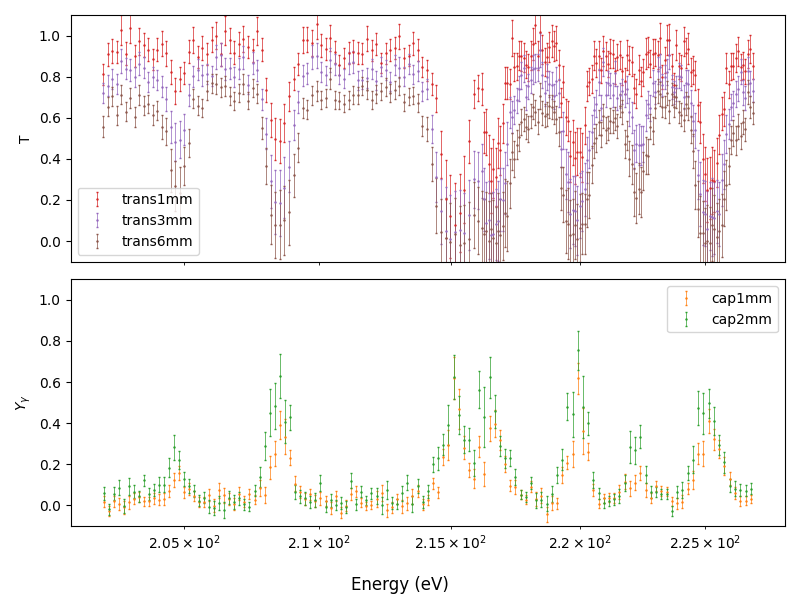

In [6]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]
covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)


fig = plot(datasets, experiments)
fig.tight_layout()

In [7]:
## Could also plot covariance here

In [8]:
# all options to run! 
settings = {
    'path_to_SAMMY_exe': '/home/fire/SAMMY/sammy/build/install/bin/sammy',
    'path_to_SAMMY_temps': './sammy_temps/',
    'keep_runDIR_SAMMY': True,
    'shell_SAMMY': 'bash',
}

# folder where to save all
savefolder = './data/'
fig_size = (10,6)

Gn_thr = 0.01
N_red = 50 # number of resonances to keep after the initial autofit

chi2_allowed = 0
fit_all_spin_groups = True

## Fit from ENDF or JEFF

In [9]:
sammyRTO = sammy_classes.SammyRunTimeOptions(#'/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                            sammyexe=settings['path_to_SAMMY_exe'],
                            options= {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = "/Users/noahwalton/research_local/data/JEFF33_endf6/73-Ta-181g.jeff33"
jeff_file = "./73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_all)+5) & (jeff_parameters.E>min(energy_range_all)-5)]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*0
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))

jeff_parameters

E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
47  200.00  63.0000  31.4285    1.0     0.0      1.0   1.0
48  204.67  64.9999   2.7540    1.0     0.0      1.0   1.0
49  208.48  64.9999   9.4220    1.0     0.0      1.0   2.0
50  215.09  64.9999  48.2700    1.0     0.0      1.0   2.0
51  216.60  64.9999  19.3900    1.0     0.0      1.0   1.0
52  219.81  64.9999  12.8800    1.0     0.0      1.0   2.0
53  222.29  64.9999   2.4360    1.0     0.0      1.0   2.0
54  225.15  64.9999  20.5700    1.0     0.0      1.0   2.0
55  230.62  64.9999  22.4200    1.0     0.0      1.0   2.0

In [10]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions(
    sammyexe=settings['path_to_SAMMY_exe'],
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance=covariance_data,  #[{}, {}, {}, {}, {}], # 
    
    max_steps = 10,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.1
    )

print('Spin group keys:')
print(list(Ta_pair.spin_groups.keys()))

Spin group keys:
['3.0', '4.0']


In [11]:
# size of the dataset - to compare

# dataset size
sum_points = 0 
for index,el in enumerate(datasets):
    sum_points += el.shape[0]

print(f'Datasets: {len(datasets)}')
print(f'Num of points: {sum_points}')

Datasets: 5
Num of points: 851


In [12]:
sammyOUT_SFJ = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.1  : [2.2574, 1.9997, 1.0731, 1.478, 1.947, 8.7551]
1    0.2  : [1.873, 1.8835, 0.8834, 1.0802, 1.2841, 7.0043]
2    0.4  : [1.8743, 1.8861, 0.8807, 1.0646, 1.2664, 6.9721]
Chi2 improvement below threshold


In [13]:
# assuming that it's "true" solution



In [14]:
# prior_lsts = lsts
def printout_chi2_post(sammyOUT: sammy_classes.SammyOutputData, addstr :str = 'Solution chi2 values'):
    print(f'{addstr}')
    print('Chi2_n:')
    print('\t Prior:')
    print('\t', sammyOUT.chi2n, np.sum(sammyOUT.chi2n))
    print('\t Posterior:')
    print('\t', sammyOUT.chi2n_post, np.sum(sammyOUT.chi2n_post))

    print('Chi2:')
    print('\t Prior:')
    print('\t', sammyOUT.chi2, np.sum(sammyOUT.chi2))
    print('\t Posterior:')
    print('\t', sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

printout_chi2_post(sammyOUT_SFJ, 'JEFF')

JEFF
Chi2_n:
	 Prior:
	 [2.2574, 1.9997, 1.07307, 1.47797, 1.94697] 8.75511
	 Posterior:
	 [1.87429, 1.88612, 0.880722, 1.06459, 1.26638] 6.9721020000000005
Chi2:
	 Prior:
	 [286.689, 253.963, 213.541, 294.117, 387.446] 1435.7559999999999
	 Posterior:
	 [238.035, 239.537, 175.264, 211.854, 252.01] 1116.7


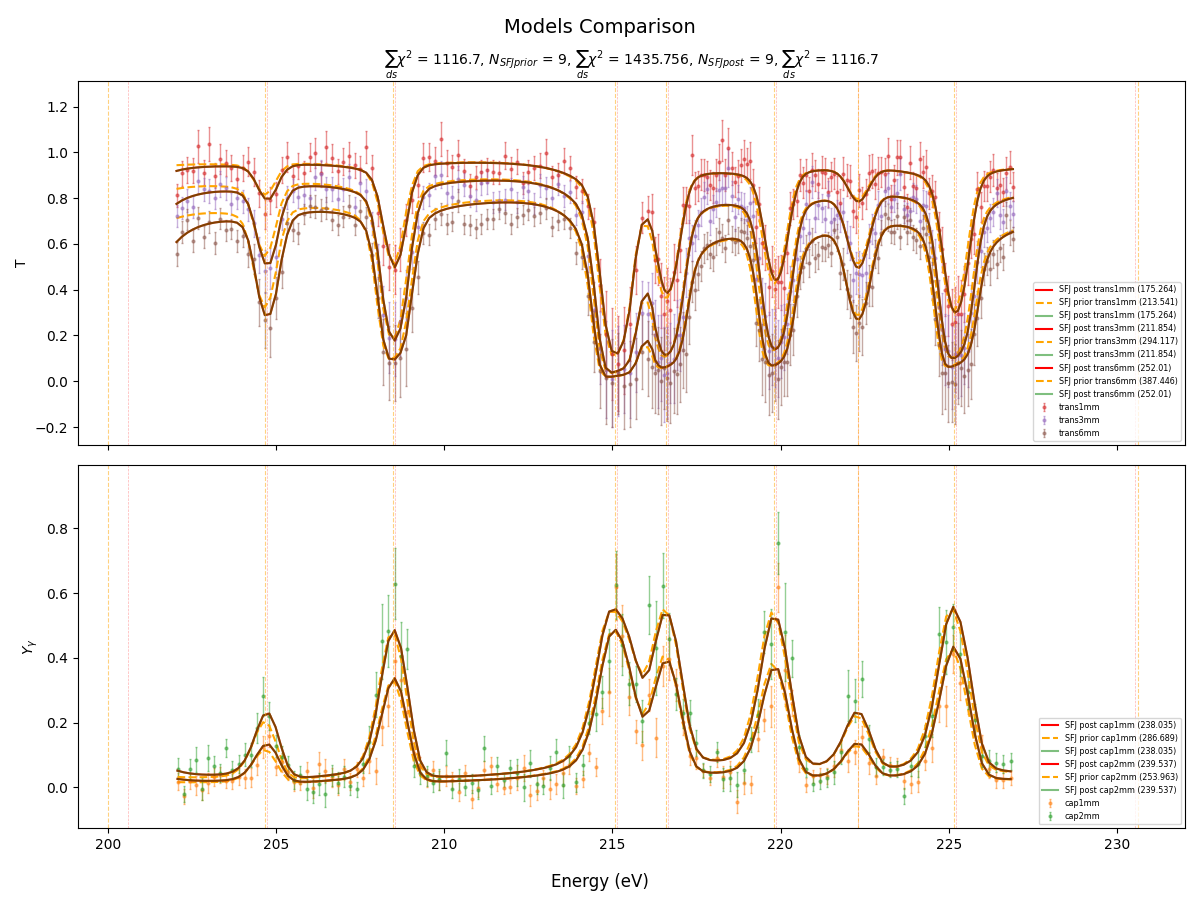

In [15]:
# fig2 = plot(datasets, experiments, fits=sammyOUT.pw_post, priors=sammyOUT.pw)
# fig2.tight_layout()

# plotting using modified func

fig2 = elim_addit_funcs.plot_datafits(datasets, experiments, 
    fits = sammyOUT_SFJ.pw_post, 
    fits_chi2 = sammyOUT_SFJ.chi2_post, 
    f_model_name = 'SFJ post',
    
    priors = sammyOUT_SFJ.pw, priors_chi2 = sammyOUT_SFJ.chi2, pr_model_name='SFJ prior',

    true = sammyOUT_SFJ.pw_post, 
    true_chi2 = sammyOUT_SFJ.chi2_post, 
    t_model_name ='SFJ post',
    
    true_pars = Ta_pair.resonance_ladder,
    
    fit_pars = sammyOUT_SFJ.par_post,
    prior_pars = sammyOUT_SFJ.par,
      
    title = 'Models Comparison',
    show_spingroups = False,
    #fig_size = fig_size
    )

fig2.savefig(fname=savefolder+'SFJ_Fit_Result.png')
fig2.show()

In [16]:
sammyOUT_SFJ.par_post

E       Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0  200.597668  63.0000  46.040026    1.0     0.0      1.0   1.0
1  204.736081  64.9999   3.201680    1.0     0.0      1.0   1.0
2  208.528662  64.9999   9.772182    1.0     0.0      1.0   2.0
3  215.121357  64.9999  45.192296    1.0     0.0      1.0   2.0
4  216.637889  64.9999  17.922388    1.0     0.0      1.0   1.0
5  219.868096  64.9999  12.336178    1.0     0.0      1.0   2.0
6  222.305115  64.9999   2.650817    1.0     0.0      1.0   2.0
7  225.211309  64.9999  21.304218    1.0     0.0      1.0   2.0
8  230.529015  64.9999  21.960269    1.0     0.0      1.0   2.0

In [17]:
# utilizing the autofit from initial FB

from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

sammy_rto_fit = sammy_classes.SammyRunTimeOptions(
    sammyexe=settings['path_to_SAMMY_exe'],
                             options = {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })


options = InitialFBOPT(GGn_threshold=Gn_thr,
                       iterations=3,
                       max_steps = 30,
                       step_threshold=0.01,
                       LevMarV0=0.05,
                       fit_all_spin_groups=fit_all_spin_groups,
                       spin_group_keys = ['3.0']
                       )

autofit_initial = InitialFB(options)

In [18]:
outs = autofit_initial.fit(Ta_pair,
                               energy_range_all,
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 62 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
0    0.05 : [8.4998, 9.9908, 0.2667, 0.5572, 0.7823, 20.0968]
1    0.075: [8.4927, 9.9786, 0.2662, 0.554, 0.7744, 20.066]
2    0.113: [8.4761, 9.95, 0.2651, 0.5468, 0.7568, 19.9949]
3    0.169: [8.4354, 9.8807, 0.2624, 0.5304, 0.7178, 19.8268]
4    0.253: [8.3274, 9.6993, 0.256, 0.4934, 0.6368, 19.4129]
5    0.38 : [8.0213, 9.1978, 0.2422, 0.4289, 0.5355, 18.4257]
6    0.57 : [7.2253, 7.9616, 0.2269, 0.3974, 0.5855, 16.3966]
7    0.854: [5.4443, 5.6192, 0.2266, 0.5182, 0.9484, 12.7568]
8    1.281: [4.3434, 4.5196, 0.2551, 0.7419, 1.3972, 11.2572]
9    1.922: [4.2073, 4.4312, 0.2602, 0.7783, 1.4603, 11.1373]
Repeat step 10, 	fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum']
		0.384: [4.2094, 4.4358, 0.2604, 0.7767, 1.4568, 11.1392]
		0.077: [4.2093, 4.4329, 0.2604, 0.7775, 1.4584, 11.1385]
		0.015: [4.207

In [19]:
print(f'Num elements in outs (stages): {len(outs)}')
printout_chi2_post(outs[-1], 'autofit result')
#print(outs[-1].par_post)

printout_chi2_post(outs[0], 'autofit prior')

Num elements in outs (stages): 1
autofit result
Chi2_n:
	 Prior:
	 [4.20731, 4.43123, 0.260173, 0.778295, 1.46029] 11.137298
	 Posterior:
	 [1.80913, 2.0324, 0.431402, 0.513936, 0.767087] 5.553955
Chi2:
	 Prior:
	 [534.328, 562.767, 51.7744, 154.881, 290.597] 1594.3474
	 Posterior:
	 [229.76, 258.115, 85.849, 102.273, 152.65] 828.647
autofit prior
Chi2_n:
	 Prior:
	 [4.20731, 4.43123, 0.260173, 0.778295, 1.46029] 11.137298
	 Posterior:
	 [1.80913, 2.0324, 0.431402, 0.513936, 0.767087] 5.553955
Chi2:
	 Prior:
	 [534.328, 562.767, 51.7744, 154.881, 290.597] 1594.3474
	 Posterior:
	 [229.76, 258.115, 85.849, 102.273, 152.65] 828.647


In [20]:
# saving initial solution & chars
f_name_to_save = f'Autofit_init_res_sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}.pkl'

save_obj  = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, 
                                             file_name=f_name_to_save,
                                             obj = outs)

In [21]:
# reading the prefitted data
f_name_to_load = f_name_to_save

outs = elim_addit_funcs.load_obj_from_pkl(folder_name=savefolder, 
                                          pkl_fname=f_name_to_load)
final_fb_output = outs[-1]

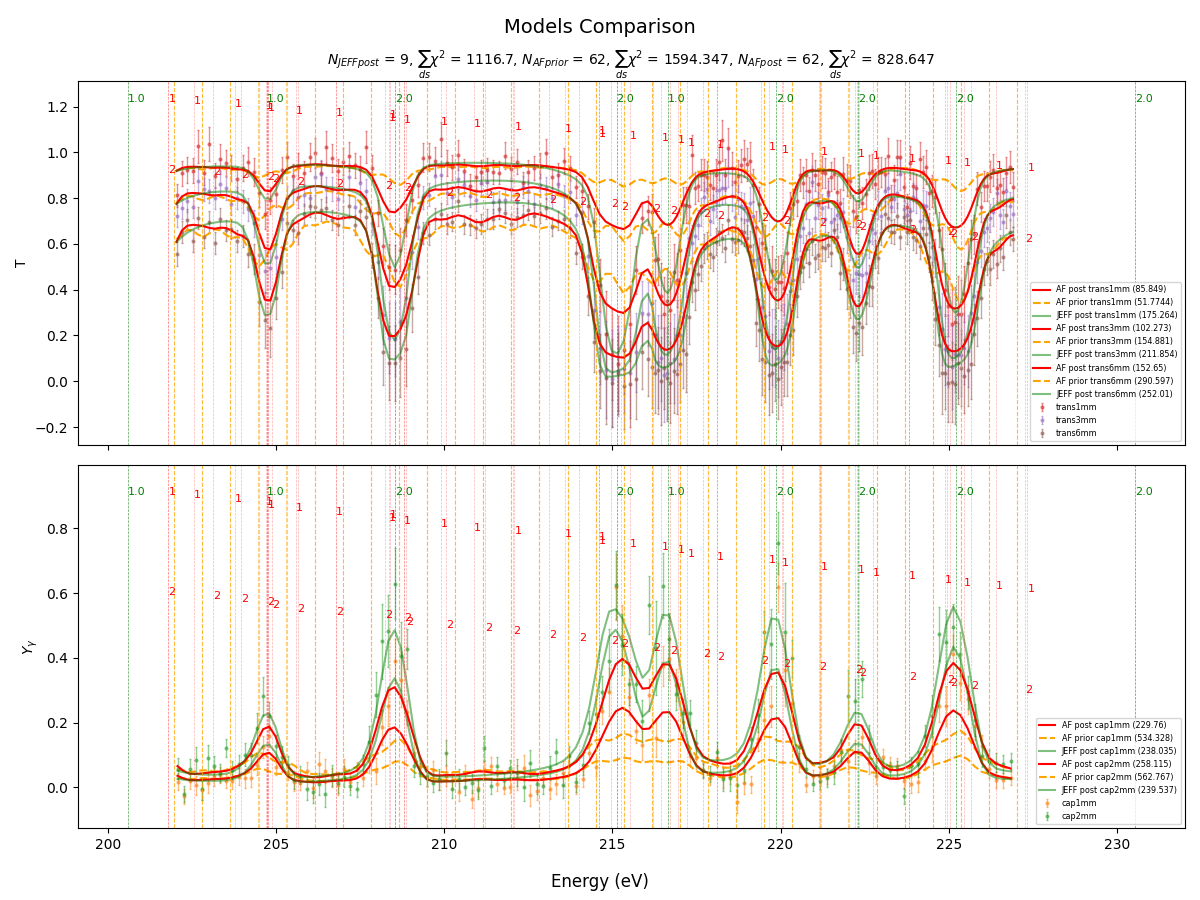

In [22]:

# plotting to show pos. of resonances
fig2 = elim_addit_funcs.plot_datafits(datasets, experiments, 
    fits = final_fb_output.pw_post, 
    fits_chi2 = final_fb_output.chi2_post, 
    f_model_name='AF post',
    
    priors = final_fb_output.pw, priors_chi2=final_fb_output.chi2, pr_model_name='AF prior',

    true=sammyOUT_SFJ.pw_post, # TODO: philosophy
    true_chi2 = sammyOUT_SFJ.chi2_post, 
    t_model_name ='JEFF post', 

    true_pars = sammyOUT_SFJ.par_post,
    fit_pars = final_fb_output.par_post,
    prior_pars = final_fb_output.par,
      
    title = 'Models Comparison',
    show_spingroups = True,
    #fig_size = fig_size
    )

fig2.savefig(fname=savefolder+'Initial_Fit_Result.png')
fig2.show()

In [23]:
print(final_fb_output.chi2)
print(sum(final_fb_output.chi2))
print(final_fb_output.chi2_post)
print(sum(final_fb_output.chi2_post))
print(f'N_res: {final_fb_output.par_post.shape[0]}')

[534.328, 562.767, 51.7744, 154.881, 290.597]
1594.3474
[229.76, 258.115, 85.849, 102.273, 152.65]
828.647
N_res: 62


***A measure of error***

Input Energy grid
2500
build_residual_matrix_dict
Energy grid fine:
2500
Completed Job: 1


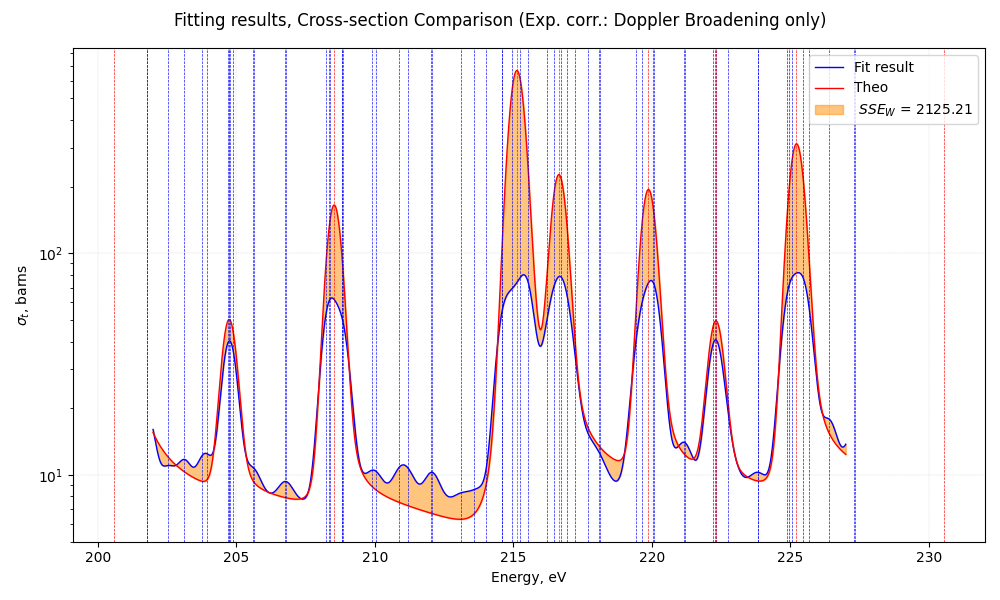

In [24]:
# run
from ATARI.utils.misc import fine_egrid

importlib.reload(elim_addit_funcs)

energy_grid = fine_egrid(energy = energy_range_all)

df_est, df_theo, resid_matrix, SSE_dict, xs_figure = elim_addit_funcs.calc_all_SSE_gen_XS_plot(
        est_ladder = final_fb_output.par_post,
        theo_ladder = sammyOUT_SFJ.par_post,
        Ta_pair = Ta_pair,
        settings = settings,
        energy_grid=energy_grid,
        reactions_SSE = ['capture', 'elastic'],
        fig_size=fig_size,
        calc_fig=True
)

xs_figure.show()
xs_figure.savefig(fname=savefolder+'xs_Initial_Fit_Result.png')

# Resonance elimination 


In [25]:
import importlib

importlib.reload(chi2_eliminator_v2)
importlib.reload(elim_addit_funcs)

start_ladder = final_fb_output.par_post
assert isinstance(start_ladder, pd.DataFrame)

# side resonances if needed, otherways - keep empty
side_resonances_df = pd.DataFrame()

side_resonances_df = elim_addit_funcs.find_side_res_df(
        initial_sol_df = jeff_parameters,
        energy_region = energy_range_all,
        N_res = 2
)

side_resonances_df = elim_addit_funcs.set_varying_fixed_params(ladder_df=side_resonances_df,
                                                               vary_list=[0,1,1])
print('Side resonances:')
print(side_resonances_df)


# compiling to one ladder
start_ladder = pd.concat([side_resonances_df, start_ladder], ignore_index=True)
print('Final ladder to eliminate from')
print(start_ladder)


Side resonances:
         E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
47  200.00  63.0000  31.4285      0       1        1   1.0
55  230.62  64.9999  22.4200      0       1        1   2.0
Final ladder to eliminate from
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000  63.000000  31.428500    0.0     1.0      1.0   1.0
1   230.620000  64.999900  22.420000    0.0     1.0      1.0   2.0
2   201.794810  57.688987   0.425855    1.0     1.0      1.0   1.0
3   202.544853  62.210111   0.202011    1.0     1.0      1.0   1.0
4   203.778094  64.701601   0.183264    1.0     1.0      1.0   1.0
..         ...        ...        ...    ...     ...      ...   ...
59  223.820964  64.111724   0.047099    1.0     1.0      1.0   2.0
60  224.953560  58.688613   0.133154    1.0     1.0      1.0   2.0
61  225.047577  68.122194   1.890375    1.0     1.0      1.0   2.0
62  225.658998  57.042290   0.600030    1.0     1.0      1.0   2.0
63  227.280272  63.488000   0.196317  

In [26]:
# if we do not want to wait hours...

N_red = min(N_red, start_ladder.shape[0],) # not limiting

# just to reduce processing time
start_ladder = elim_addit_funcs.reduce_ladder(ladder_df=start_ladder,
                             Gn1_threshold=Gn_thr,
                             vary_list=[1,0,1],
                             N=N_red,
                             keep_fixed=True,
                             fixed_side_resonances=side_resonances_df)

print('Start ladder:')
print(start_ladder)


Found side resonances (fixed):
        E       Gg      Gn1  varyE  varyGg  varyGn1  J_ID
0  200.00  63.0000  31.4285    0.0     1.0      1.0   1.0
1  230.62  64.9999  22.4200    0.0     1.0      1.0   2.0
Keeping them: True
Reduced number of resonances from 64 to 37
Threshold used: 0.01
Eliminated 27 resonances
Start ladder:
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000  63.000000  31.428500    0.0     1.0      1.0   1.0
1   201.794810  57.688987   0.425855    1.0     0.0      1.0   1.0
2   201.795421  58.644932   0.295240    1.0     0.0      1.0   2.0
3   203.130298  59.390248   0.210183    1.0     0.0      1.0   2.0
4   204.691972  59.170242   0.384910    1.0     0.0      1.0   1.0
5   204.742816  49.333006   0.958927    1.0     0.0      1.0   2.0
6   204.760325  54.533379   0.631791    1.0     0.0      1.0   1.0
7   208.230422  53.723692   0.645503    1.0     0.0      1.0   2.0
8   208.353634  54.782834   0.303324    1.0     0.0      1.0   1.0
9  

In [27]:

# defining rto & inputs
elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 0,
    iterations = 2,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = chi2_allowed,
                                         stop_at_chi2_thr = False,
                                      fixed_resonances_df = side_resonances_df,
                                      deep_fit_max_iter = 30,
                                      deep_fit_step_thr = 0.01,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

In [28]:
elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

In [29]:
hist = elimi.eliminate(ladder_df= start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 0


Input ladder:
             E         Gg        Gn1  varyE  varyGg  varyGn1  J_ID
0   200.000000  63.000000  31.428500    0.0     1.0      1.0   1.0
1   201.794810  57.688987   0.425855    1.0     0.0      1.0   1.0
2   201.795421  58.644932   0.295240    1.0     0.0      1.0   2.0
3   203.130298  59.390248   0.210183    1.0     0.0      1.0   2.0
4   204.691972  59.170242   0.384910    1.0     0.0      1.0   1.0
5   204.742816  49.333006   0.958927    1.0     0.0      1.0   2.0
6   204.760325  54.533379   0.631791    1.0     0.0      1.0   1.0
7   208.230422  53.723692   0.645503    1.0     0.0      1.0   2.0
8   208.353634  54.782834   0.303324    1.0     0.0      1.0   1.0
9   208.373660  29.285365   2.517553    1.0     0.0      1.0   1.0
10  208.808337  56.901220   0.333821    1.0     0.0      1.0   1.0
11  208.815821  4

In [30]:
# # true - using JEFF? just for comparison

# true_chars = elimi.evaluate_prior(jeff_parameters) 
# print(true_chars.chi2)

true_chars = sammyOUT_SFJ

In [31]:
# just to show how much we aliminated with the given threshold value.
print(f'Eliminated from {hist.ladder_IN.shape[0]} res -> {hist.ladder_OUT.shape[0]}')
print(f'Elim took {np.round(hist.elim_tot_time,2)} sec')

Eliminated from 37 res -> 29
Elim took 25753.98 sec


In [32]:
# save history?

# can we save the history not to refit all the time?

fitted_elim_case_data = {
        'datasets' : datasets,
        'covariance_data' : covariance_data,
    'experiments': experiments,
    'true_chars': true_chars, # note, jeff are used as true here
    'Ta_pair': Ta_pair,
}
if (fit_all_spin_groups):
    f_name_to_save = f'sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}_allspingr'
else:
    f_name_to_save = f'sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}'

saved_hist = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name=f'hist_{f_name_to_save}.pkl', obj=hist)
saved_data = elim_addit_funcs.save_obj_as_pkl(folder_name=savefolder, file_name=f'dataset_{f_name_to_save}.pkl', obj=fitted_elim_case_data)


Initial ladder, num of res.: 37


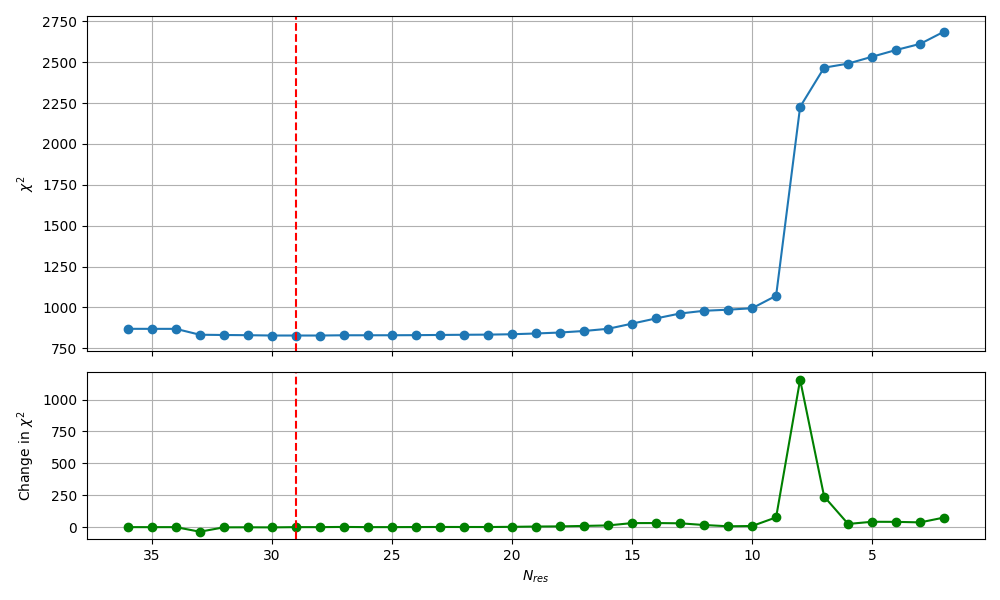

In [33]:
# plot the final selected fit?
# images production from history

prior_level = max(hist.elimination_history.keys())
prior_numres = hist.elimination_history[prior_level]['input_ladder'].shape[0]
print(f'Initial ladder, num of res.: {prior_numres}')

min_level_passed_test = prior_level # level - key in the hist..
min_N_res_passed_test = prior_level - 1

levels = []
N_ress = []
chi2_s = []

for level in hist.elimination_history.keys():
        
    numres = hist.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
    pass_test = hist.elimination_history[level]['final_model_passed_test']

    #print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')

    if (pass_test and level<min_level_passed_test):
        min_level_passed_test = level

        min_N_res_passed_test = numres
    
    levels.append(level)
    chi2_s.append(np.sum(hist.elimination_history[level]['selected_ladder_chars'].chi2_post))
    N_ress.append(numres)

# plotting    

# differences in chi2 values between 2 models
chi2_diffs = np.diff(chi2_s, prepend=chi2_s[0]) 

fig, (ax1, ax2) = subplots(2, 1, figsize = fig_size, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# First subplot for the original chi2 values
ax1.plot(N_ress, chi2_s, marker='o')
ax1.axvline(x=min_N_res_passed_test, color='r', linestyle='--')

ax1.set_ylabel('$\chi^2$')
ax1.grid(True)

# changes in chi2

ax2.plot(N_ress, chi2_diffs, marker='o', color='green')
ax2.axvline(x=min_N_res_passed_test, color='r', linestyle='--')
ax2.set_xlabel(r'$N_{res}$')
ax2.set_ylabel('Change in $\chi^2$')
ax2.invert_xaxis()
ax2.grid(True)

tight_layout()
f_name_to_save = f'hist_sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}'
fig.savefig(savefolder+f'{f_name_to_save}.png')
show()

In [34]:
# plotting data from history
def show_plot_from_hist(
        datasets,
        experiments,
        true_chars,
        true_pars,

        level_to_compare: int,
        min_level_passed_test: int,
        elim_hist: dict,
        addit_title_str: str = ''
        ):
    
    fits = elim_hist[level_to_compare]['selected_ladder_chars'].pw_post
    fits_chi2 = elim_hist[level_to_compare]['selected_ladder_chars'].chi2_post

    prior_fit = elim_hist[prior_level]['selected_ladder_chars'].pw
    priors_chi2 = elim_hist[prior_level]['selected_ladder_chars'].chi2

    # outfit
    fig = elim_addit_funcs.plot_datafits(datasets, experiments, 
        fits=fits, fits_chi2=fits_chi2, f_model_name=f'AF + el. {N_red}',
        priors = prior_fit, priors_chi2=priors_chi2, pr_model_name=f'AF, red. to {N_red}',
        true=true_chars.pw, t_model_name='JEFF (w/o autofit)',
        true_chi2 = true_chars.chi2,
        true_pars = true_pars,
        fit_pars = elim_hist[level_to_compare]['selected_ladder_chars'].par_post,
        prior_pars = elim_hist[prior_level]['input_ladder'],
        title = f'Fit, Prior & True comparison, model # {level_to_compare}, best selected: {min_level_passed_test} '+addit_title_str,
        show_spingroups=True
        )
    fig.tight_layout()
    return fig

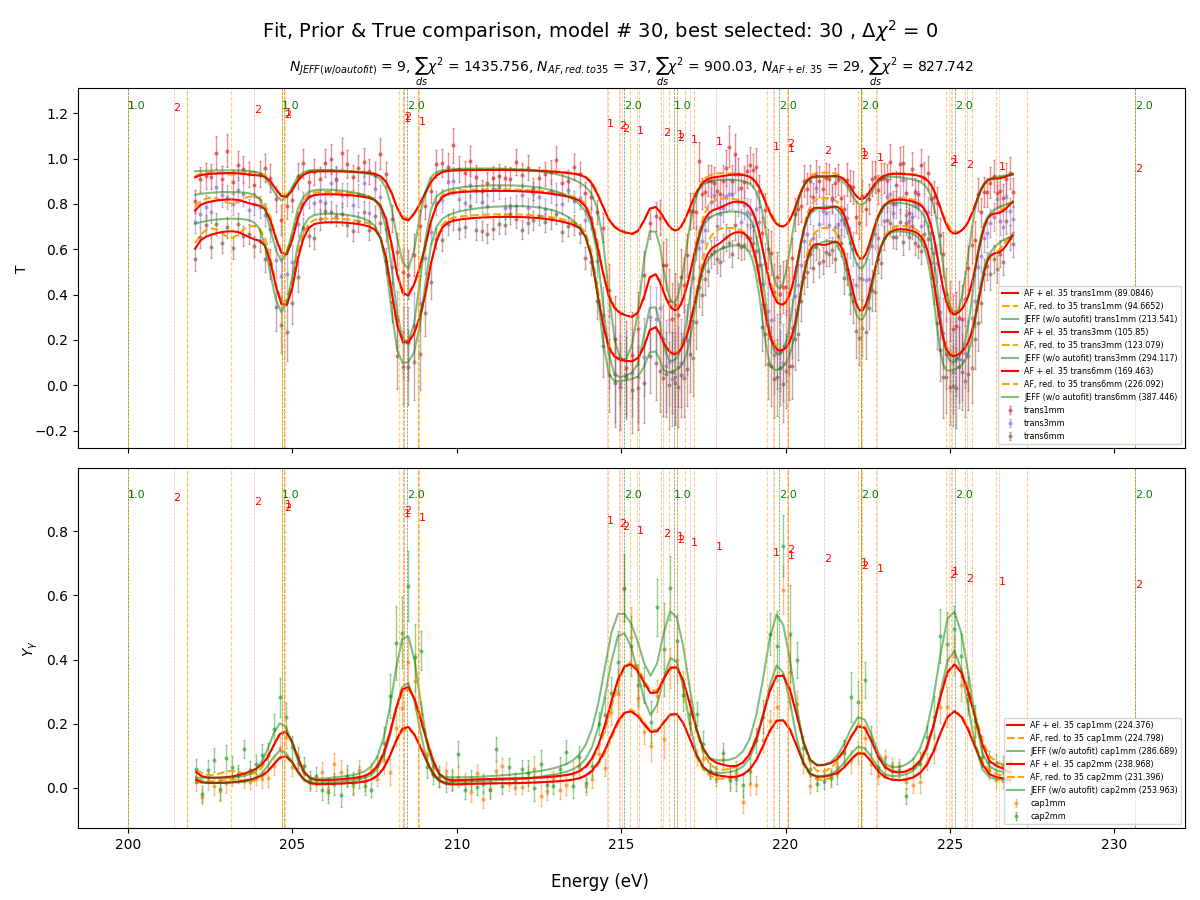

In [38]:
N_res_to_view = min_N_res_passed_test
level_to_compare = N_res_to_view+1

fig = show_plot_from_hist(datasets = datasets,
                          experiments=experiments,
                          true_chars = true_chars,
                          true_pars = true_chars.par,
                          level_to_compare=level_to_compare,
                          min_level_passed_test= min_level_passed_test,
                          elim_hist = hist.elimination_history,
                          addit_title_str=', $\Delta\chi^2$ = '+str(chi2_allowed)
                          )

fig.savefig(savefolder+f'elim_result_sel_sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}.png')
fig.show()

In [36]:
# table for analysis of the models - produce chi2

importlib.reload(elim_addit_funcs)

# sums - for all datasets
NLLW_s = []
chi2_s = []
aicc_s = []
bicc_s = []
N_res_s = []
test_pass = []

N_res_joint_LL = []

for level in hist.elimination_history.keys():
        
    numres = hist.elimination_history[level]['selected_ladder_chars'].par_post.shape[0]
    pass_test = hist.elimination_history[level]['final_model_passed_test']

    # print(f'level {level}, # of resonances: {numres},  passed the test: {pass_test}')
    cur_ch_dict = elim_addit_funcs.characterize_sol(Ta_pair=Ta_pair,
                     datasets=datasets,
                     experiments=experiments,
                     sol = hist.elimination_history[level]['selected_ladder_chars'],
                     covariance_data = covariance_data
                     )
    
    N_res_s.append(numres)
    test_pass.append(pass_test)
    chi2_s.append(sum(cur_ch_dict['chi2_stat']))
    
    # aicc_s.append(sum(cur_ch_dict['aicc']))
    # bicc_s.append(sum(cur_ch_dict['bicc']))

    aicc_s.append(cur_ch_dict['aicc_entire_ds'])
    bicc_s.append(cur_ch_dict['bic_entire_ds'])

    NLLW_s.append(sum(cur_ch_dict['NLLW'].values()))
    N_res_joint_LL.append(cur_ch_dict['N_res_joint_LL'])


    # levels.append(level)
    # chi2_s.append(np.sum(hist.elimination_history[level]['selected_ladder_chars'].chi2_post))
    # N_ress.append(numres)
    print(cur_ch_dict )

# combine to one DataFrame
table_df = pd.DataFrame.from_dict({
    'N_res': N_res_s,
    'N_res_joint_LL': N_res_joint_LL,
    'passed': test_pass,
    'sum_chi2': chi2_s,
    'sum_NLLW': NLLW_s,
    'AICc': aicc_s,
    'BIC': bicc_s

})

# calculating deltas in BIC and AICc
table_df['delta_AICc_best'] = table_df['AICc'] - table_df['AICc'].min()
table_df['delta_BIC_best'] = table_df['BIC'] - table_df['BIC'].min()
table_df['delta_chi2_prev'] = table_df['sum_chi2'].diff().fillna(0)
table_df['delta_chi2_best'] = table_df['sum_chi2'] - table_df['sum_chi2'].min()

# saving comparison table
table_df.to_csv(path_or_buf=savefolder+f'comparison_sf_{N_red}_er[{np.min(energy_range_all)}_{np.max(energy_range_all)}]_chi2allowed_{chi2_allowed}.csv')
table_df

Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
Warning - using precalculated chi2 value
Using cov data for chi2 calc
{'aic': [438.695, 447.1, 309.14, 334.784, 419.051], 'aicc': [1746.695, 1755.1, 570.74, 596.384, 680.6510000000001], 'bic': [745.8672053375278, 754.2722053375279, 664.8169210702451, 690.4609210702451, 774.7279210702452], 'bicc': [1399.8672053375278, 1408.2722053375278, 795.6169210702451, 821.2609210702451, 905.5279210702452], 'chi2_stat': [222.695, 231.1, 93.14, 118.784, 203.051], 'aicc_entire_ds': 1119.131673414305, 'bic_entire_ds': 1604.1289220144977, 'NLLW': {'3.0': 77.58247156585558, '4.0': 47.97756515543151}, 'N_res_prob_by_spingr': {'3.0': 2.2250738585072014e-308, '4.0': 2.2250738585072014e-308}, 'N_res_joint_prob': 0.0, 'N_res_joint_LL'

N_res  N_res_joint_LL  passed   sum_chi2    sum_NLLW         AICc  \
0      36    -1416.792837    True   868.7700  125.560037  1119.131673   
1      35    -1416.792837    True   868.5898  119.733774  1111.079047   
2      34    -1416.792837    True   868.5541  115.762934  1103.234154   
3      33    -1416.792837    True   832.5499  107.583519  1059.483233   
4      32    -1416.792837    True   830.9672  101.420389  1050.215540   
5      31    -1416.792837    True   829.7111   96.602006  1041.335439   
6      30    -1416.792837    True   827.7821   93.011785  1031.842706   
7      29    -1416.792837    True   827.7416   86.507824  1024.298030   
8      28    -1416.792837   False   827.7329   83.794706  1016.844011   
9      27     -717.606759   False   829.2848   79.098673  1011.008758   
10     26     -715.660849   False   829.2874   73.983899  1003.681693   
11     25     -715.409534   False   829.4406   68.822467   996.562047   
12     24     -716.508147   False   830.0325   66.051072   989.937262   
13     23     -713.893187   False   831.2368   62.897517   983.980390   
14     22     -714.051411   False   832.3422   58.055426   977.979492   
15     21     -714.023240   False   833.2419   53.188234   971.827142   
16     20     -712.173037   False   835.5583   49.488606   967.145119   
17     19     -710.901120   False   840.2528   46.490159   964.894214   
18     18     -710.886539   False   846.0878   44.593160   963.836228   
19     17     -709.946173   False   855.5353   43.819267   966.442568   
20     16     -709.559569   False   868.8832   42.274368   973.000553   
21     15     -709.703532   False   900.4690   44.074539   997.847109   
22     14     -709.711695   False   932.4300   40.221378  1023.118971   
23     13       -9.463041   False   962.4420   35.525647  1046.491383   
24     12       -6.477955   False   979.0790   33.283425  1056.537795   
25     11       -4.583037   False   985.7710   28.059753  1056.687667   
26     10       -3.128582   False   994.5880   26.477480  1059.010466   
27      9       -2.297058   False  1071.0430   21.829067  1129.018669   
28      8       -3.355311   False  2226.4750   22.468646  2278.050758   
29      7       -5.696609   False  2466.3780   27.343546  2511.600222   
30      6      -10.177135   False  2491.3374   25.409788  2530.251961   
31      5      -10.341993   False  2533.3371   22.848788  2565.989378   
32      4     -709.501753   False  2574.6734    7.148261  2601.108286   
33      3     -711.219880   False  2611.8786    5.050761  2632.140505   
34      2    -1416.792837   False  2687.3120    0.000000  2701.444859   

            BIC  delta_AICc_best  delta_BIC_best  delta_chi2_prev  \
0   1604.128922       155.295446      404.671528           0.0000   
1   1583.709486       147.242820      384.252091          -0.1802   
2   1563.434549       139.397926      363.977155          -0.0357   
3   1507.191113        95.647006      307.733719         -36.0042   
4   1485.369176        86.379312      285.911782          -1.5827   
5   1463.873840        77.499211      264.416446          -1.2561   
6   1441.705604        68.006478      242.248209          -1.9290   
7   1421.425867        60.461803      221.968473          -0.0405   
8   1401.177931        53.007783      201.720537          -0.0087   
9   1382.490595        47.172531      183.033200           1.5519   
10  1362.253958        39.845465      162.796564           0.0026   
11  1342.167922        32.725819      142.710527           0.1532   
12  1322.520585        26.101034      123.063191           0.5919   
13  1303.485649        20.144162      104.028255           1.2043   
14  1284.351813        14.143265       84.894418           1.1054   
15  1265.012276         7.990914       65.554882           0.8997   
16  1247.089440         3.308891       47.632046           2.3164   
17  1231.544703         1.057986       32.087309           4.6945   
18  1217.140467         0.000000       17.683073           5.835

In [37]:
# # Print the DataFrame without the index
# print(table_df.to_csv(index=False))